## Part 1: Import statements

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from collections import Counter


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Part 2: Importing cleaned data

In [27]:
data = pd.read_csv("Data/processed_data.csv", index_col=0)
data = data.dropna()
data

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1
...,...,...
25291,yous muthafin lie right tl trash mine bible sc...,1
25292,youve gone broke wrong heababy drove redneck c...,2
25294,young buck wan na eat dat nigguh like aint fuc...,1
25295,youu got wild bitches tellin lies,1


In [28]:
number_tweets = len(data["tweet"])
print(f"Number of sentences: {number_tweets}")

Number of sentences: 23865


## Part 3: Splitting Data

In [29]:

#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(data['tweet'], data['class'],  test_size=0.2, random_state=42)

In [30]:
#splitting the data into train and validation
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, random_state=42)

In [31]:
X_train.sample(5)

20688                    icepick punk bitch blood mosh pit
12703    life aint shit bitches money pass weed like st...
14028    would cut best tight end resign trash nigga ca...
800      son bitch moment walking house dark stub littl...
18288    richard grenell wapos greg sargent mocks voter...
Name: tweet, dtype: object

## Checking vocabulary size

Count Vectorization to check vocabulary size

In [32]:
#Count Vectorizing the X_train
count_vec = CountVectorizer()
count_vec.fit(X_train)

X_train_count = count_vec.transform(X_train)
X_train_count = X_train_count.toarray()

#Count Vectorizing the X_cv
X_cv_count = count_vec.transform(X_cv)
X_cv_count = X_cv_count.toarray()

#Count Vectorizing the X_test
X_test_count = count_vec.transform(X_test)
X_test_count = X_test_count.toarray()

count_vec.vocabulary_

{'stop': 13309,
 'spoiling': 12986,
 'fags': 4628,
 'wcw': 15221,
 'babes': 805,
 'love': 8196,
 'thse': 14058,
 'sexy': 12145,
 'bitches': 1302,
 'bestfriend': 1181,
 'babe': 804,
 'yanks': 15762,
 'coming': 2736,
 'disparagement': 3764,
 'pride': 10705,
 'rather': 11121,
 'jack': 7110,
 'fuck': 5249,
 'hoes': 6379,
 'tbh': 13780,
 'shit': 12260,
 'boring': 1545,
 'give': 5558,
 'wife': 15449,
 'lmfao': 8072,
 'little': 8038,
 'like': 7968,
 'message': 8649,
 'hoe': 6363,
 'need': 9246,
 'plan': 10391,
 'stuff': 13400,
 'thats': 13929,
 'saying': 11886,
 'ive': 7100,
 'pinto': 10352,
 'since': 12441,
 'dude': 4065,
 'iphone': 7026,
 'beginning': 1107,
 'gerryshalloweenparty': 5478,
 'halloween': 5985,
 'yesterday': 15833,
 'stupid': 13412,
 'nigger': 9376,
 'youre': 15879,
 'dismissed': 3761,
 'bitch': 1290,
 'wan': 15127,
 'na': 9137,
 'play': 10412,
 'thumper': 14070,
 'tounge': 14276,
 'punching': 10878,
 'smelly': 12671,
 'turtle': 14530,
 'pussy': 10907,
 'lady': 7669,
 'next': 9

In [33]:
print(f"Number of words in vocabulary: {len(count_vec.vocabulary_)}")

Number of words in vocabulary: 15973


In [34]:
# word_list = count_vec.get_feature_names_out()
# count_list = count_vec.toarray().sum(axis=0)

# counts = pd.DataFrame({"words":word_list, "counts":count_list})
# counts

## Tokenization

In [52]:
tokenizer = Tokenizer()

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#encoding training data
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_cv = tokenizer.texts_to_sequences(X_cv)
encoded_test = tokenizer.texts_to_sequences(X_test)

#padding sequences using the maximum sequence of the training set
max_length = max([len(sentence.split()) for sentence in X_train])


X_train_tk = pad_sequences(encoded_train,maxlen = max_length, padding = "post" )
X_cv_tk =pad_sequences(encoded_cv,maxlen = max_length, padding = "post" )
X_test_tk =pad_sequences(encoded_test,maxlen = max_length, padding = "post" )

In [41]:
vocab_size = len(tokenizer.word_index)+1

In [36]:

def oversample(X_train, y_train):
    print("Before Oversampling: {}".format(Counter(y_train)))

    # # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy='all')

    # # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
    print("After Oversampling: {}".format(Counter(y_train_over)))
    
    return X_train_over, y_train_over

In [49]:
X_train_tk_over, y_train_over = oversample(X_train_tk, y_train)


Before Oversampling: Counter({1: 11062, 2: 2437, 0: 820})
After Oversampling: Counter({1: 11062, 2: 11062, 0: 11062})


In [67]:
#  encoding target variable
y_train_over_encoded = np.eye(3)[np.array(y_train_over)]
y_cv_encoded = np.eye(3)[np.array(y_cv)]
y_test_encoded = np.eye(3)[np.array(y_test)]



array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [75]:
y_train_over_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## CNN with custom word embedding

Simple 1D Convolutional neural network to capture the sequence of words (further additions could be to add more filters for POS tags, sahpe of words etc)

In [85]:
model1 = Sequential()
model1.add(Embedding(input_dim= vocab_size, output_dim = 100, input_length = max_length))
model1.add(Conv1D(filters = 32, kernel_size = 8, activation = 'relu'))
model1.add(MaxPooling1D(pool_size=2)) #pooling to downsample feature extraction
model1.add(Flatten())
model1.add(Dense(10, activation ='relu'))
model1.add(Dense(3, activation = "softmax"))
print(model1.summary())

# model1 = Sequential()
# model1.add(Embedding(vocab_size, 100, input_length = max_length))
# model1.add(Conv1D(filters = 32, kernel_size = 8, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=2)) #pooling to downsample feature extraction
# model1.add(Flatten())
# model1.add(Dense(10, activation ='relu'))
# model1.add(Dense(1, activation = "softmax"))
# print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 conv1d_3 (Conv1D)           (None, 120, 32)           25632     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                19210     
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                      

In [87]:
model1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics =["accuracy"])
history = model1.fit(X_train_tk_over, y_train_over_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded))
##todo: add validation data


Epoch 1/10
519/519 [==============================] - 22s 41ms/step - loss: 0.4576 - accuracy: 0.8066 - val_loss: 0.4406 - val_accuracy: 0.8494
Epoch 2/10
519/519 [==============================] - 23s 43ms/step - loss: 0.0604 - accuracy: 0.9824 - val_loss: 0.5911 - val_accuracy: 0.8703
Epoch 3/10
519/519 [==============================] - 23s 45ms/step - loss: 0.0173 - accuracy: 0.9958 - val_loss: 0.7154 - val_accuracy: 0.8649
Epoch 4/10
519/519 [==============================] - 29s 55ms/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.8408 - val_accuracy: 0.8688
Epoch 5/10
519/519 [==============================] - 26s 49ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.8720 - val_accuracy: 0.8657
Epoch 6/10
519/519 [==============================] - 28s 53ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.9527 - val_accuracy: 0.8691
Epoch 7/10
519/519 [==============================] - 28s 54ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 1.0743 - val_accuracy:

evaluation

In [88]:
loss,acc = model1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 4ms/step - loss: 1.2423 - accuracy: 0.8554


In [89]:
results = pd.DataFrame(history.history)
results

,loss,accuracy,val_loss,val_accuracy
0,0.457613,0.806635,0.440587,0.849361
1,0.060403,0.982432,0.591093,0.870312
2,0.017258,0.995811,0.715399,0.864865
3,0.008542,0.998282,0.840830,0.868846
4,0.005550,0.998765,0.872031,0.865703
5,0.003357,0.999247,0.952682,0.869055
6,0.002897,0.999247,1.074348,0.863398
7,0.001184,0.999729,1.203327,0.868008
8,0.002349,0.999518,1.224479,0.861513
9,0.002292,0.999518,1.242311,0.855437


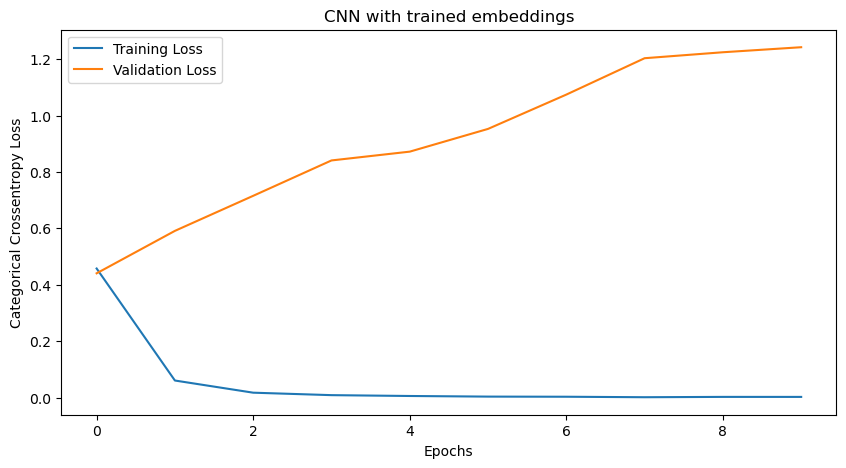

In [90]:
plt.figure(figsize = (10,5))
plt.plot(results.index, results.loss)
plt.plot(results.index, results.val_loss)
plt.title("CNN with trained embeddings")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

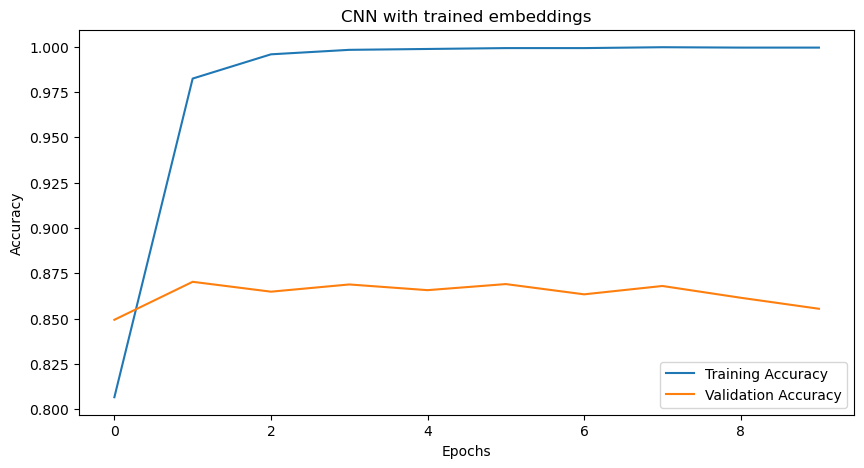

In [91]:
plt.figure(figsize = (10,5))
plt.plot(results.index, results.accuracy)
plt.plot(results.index, results.val_accuracy)
plt.title("CNN with trained embeddings")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [58]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis =1)
true_categories = tf.concat([y for x, y in val_ds], axis = 0).numpy()

150/150 [==============================] - 1s 4ms/step


array([0], dtype=int64)

## CNN with pretrained embedding: Glove

## CNN with pretrained embedding: word2vec

## Parameter search